In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Hands-on Activity 16.3: Decision making

## Objectives

+ To demonstrate how to use the results of a binary classifier to make decisions

## High melting explosives sensitivity
Let's repeat what we did for the HMX example, but after splitting the dataset into training and validation subsets.
We will be making predictions on the validation subset.

num_train = 42, num_valid = 18


<ipython-input-2-49d04950faa5>:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = train_data[:, 0].astype(np.float)
<ipython-input-2-49d04950faa5>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = train_

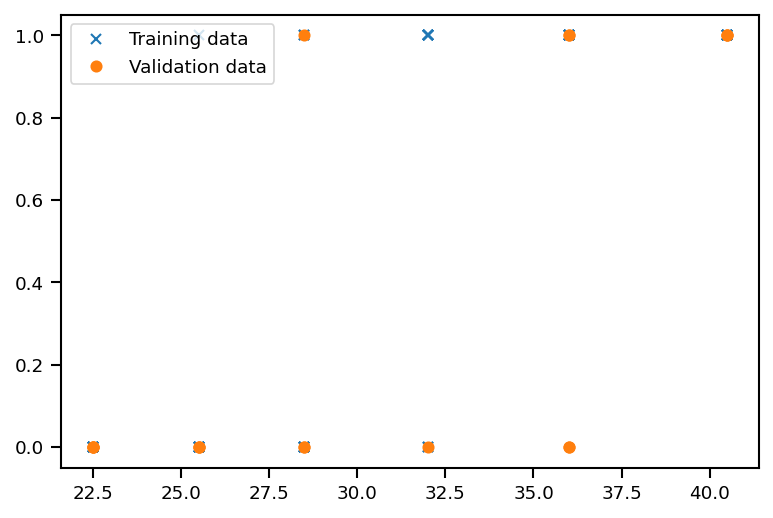

In [2]:
# Download the data file:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/hmx_data.csv'
download(url)
# Load the data using pandas
import pandas as pd
data = pd.read_csv('hmx_data.csv')
# Extract data for regression
# Heights as a numpy array
x = data['Height'].values
# The labels must be 0 and 1
# We will use a dictionary to indicate our labeling
label_coding = {'E': 1, 'N': 0}
y = np.array([label_coding[r] for r in data['Result']])
data['y'] = y

# Separate data into training and validation
num_obs = x.shape[0]
# Select what percentage you want to put in the training data
train_percentage = 0.7
# Figure out how many training points you are going to use:
num_train = int(num_obs * train_percentage)
# Figure out how many validation points you are going to use:
num_valid = num_obs - num_train
print('num_train = {0:d}, num_valid = {1:d}'.format(num_train, num_valid))

# Before splitting the data, randomly permute rows
permuted_data = np.random.permutation(data)
# Split
train_data = permuted_data[:num_train] # This picks the first n_train rows
valid_data = permuted_data[num_train:] # This puts the rest on the validation rows
# Get the x's and the y's for regression
x_train = train_data[:, 0].astype(np.float)
y_train = train_data[:, 2].astype(np.int)
x_valid = valid_data[:, 0].astype(np.float)
y_valid = valid_data[:, 2].astype(np.int)
# Let's plot the training and the validation datasets in different colors
fig, ax = plt.subplots(dpi=150)
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
plt.legend(loc='best');

Train the model:

In [3]:
from sklearn.linear_model import LogisticRegression

def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

# Make the design matrix
degree = 2
Phi_train = get_polynomial_design_matrix(x_train[:, None], degree)
model = LogisticRegression(penalty='none', fit_intercept=False).fit(Phi_train, y_train)

Make probabilistic predictions on the validation data:

In [4]:
Phi_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
predictions = model.predict_proba(Phi_valid)
print('x\tp(y=0|x)\tp(y=1|x)\tTrue label')
print('-' * 80)
for i in range(x_valid.shape[0]):
    print('{0:1.2f}\t{1:1.2f}\t\t{2:1.2f}\t\t{3:d}'.format(x_valid[i], predictions[i, 0],
                                                       predictions[i, 1], y_valid[i]))

x	p(y=0|x)	p(y=1|x)	True label
--------------------------------------------------------------------------------
40.50	0.00		1.00		1
25.50	0.91		0.09		0
28.50	0.70		0.30		0
28.50	0.70		0.30		1
22.50	0.97		0.03		0
36.00	0.01		0.99		1
28.50	0.70		0.30		0
36.00	0.01		0.99		1
25.50	0.91		0.09		0
25.50	0.91		0.09		0
36.00	0.01		0.99		0
22.50	0.97		0.03		0
36.00	0.01		0.99		0
40.50	0.00		1.00		1
40.50	0.00		1.00		1
22.50	0.97		0.03		0
22.50	0.97		0.03		0
32.00	0.21		0.79		0


And here is a nice way to visualize these probabilities:

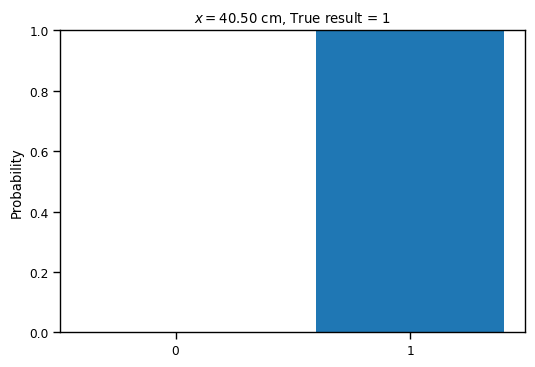

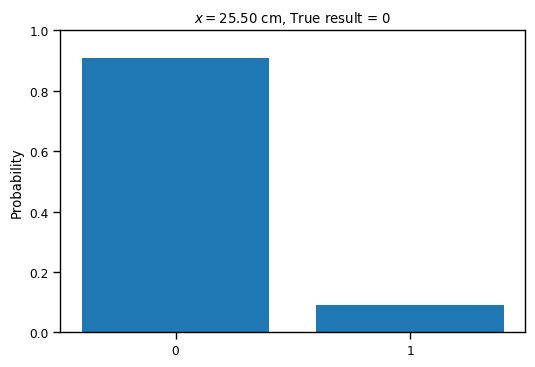

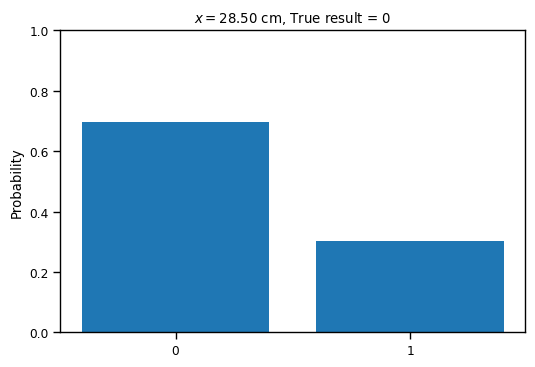

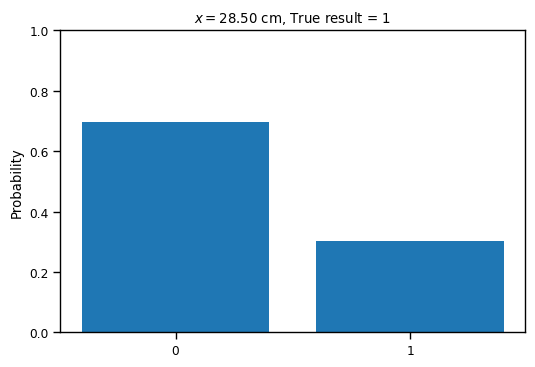

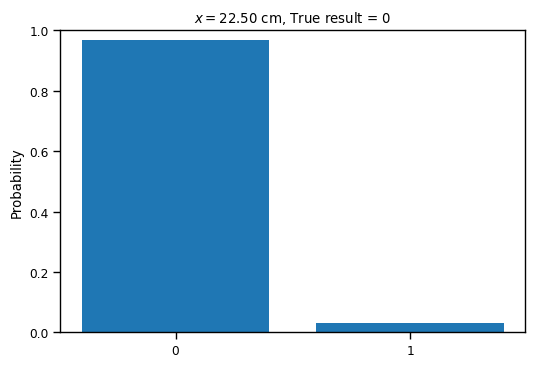

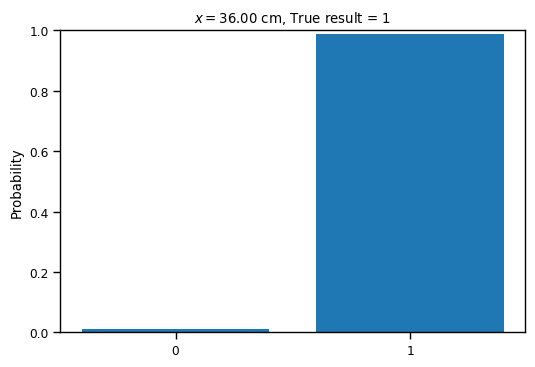

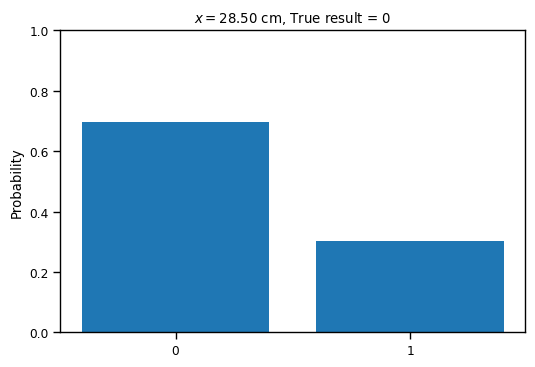

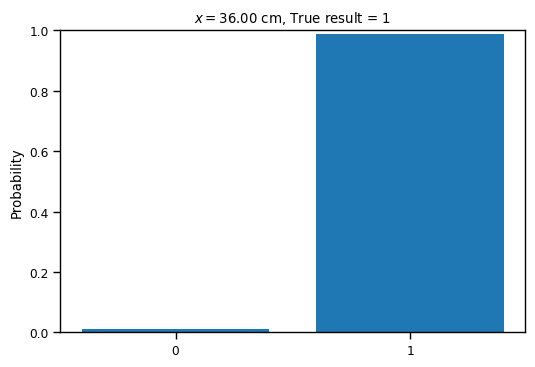

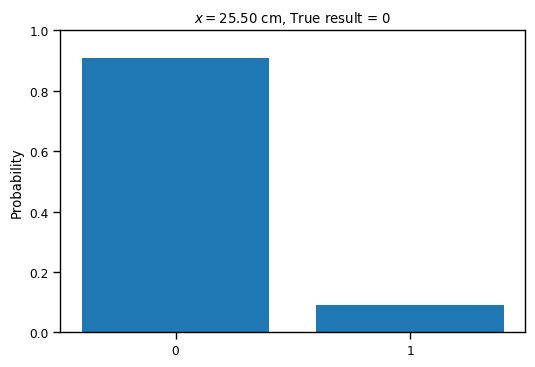

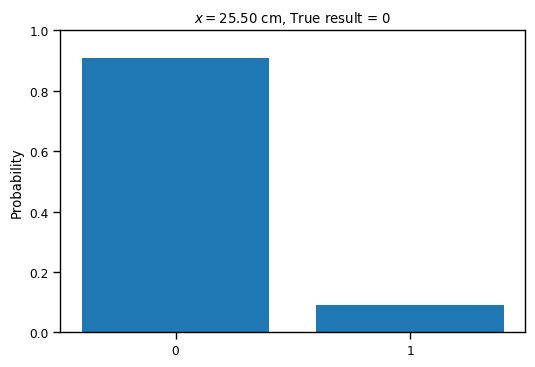

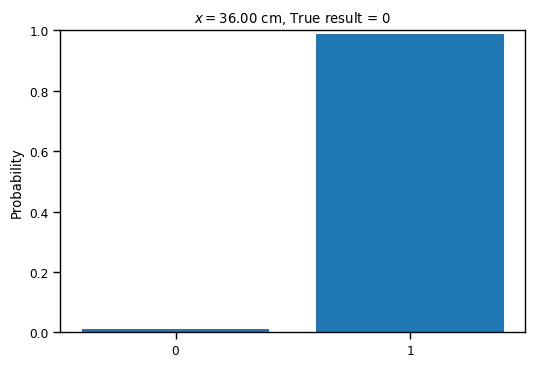

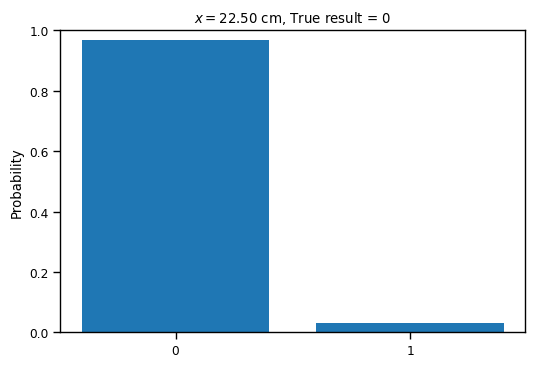

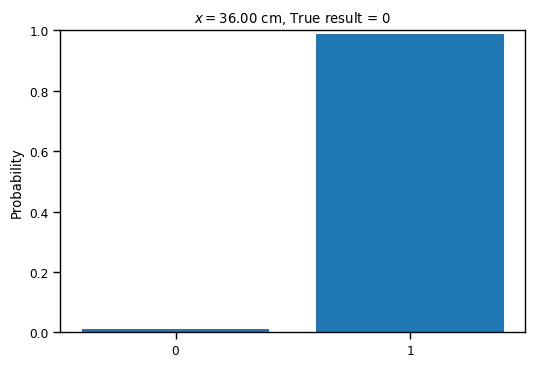

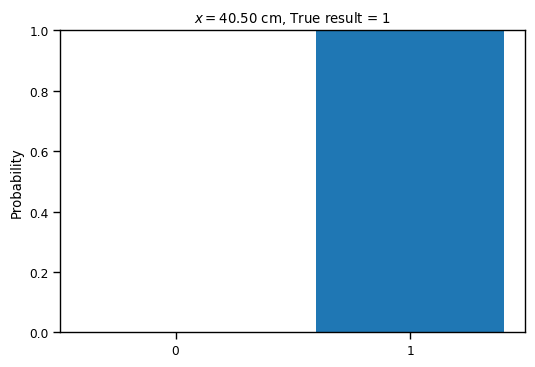

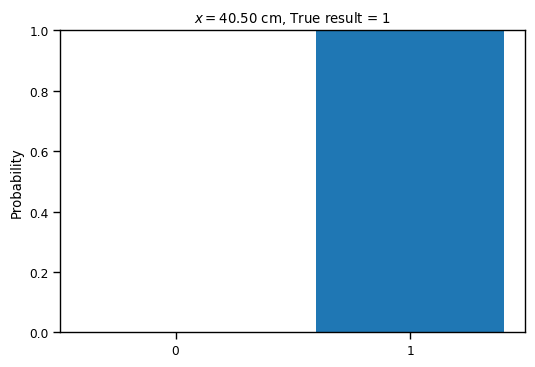

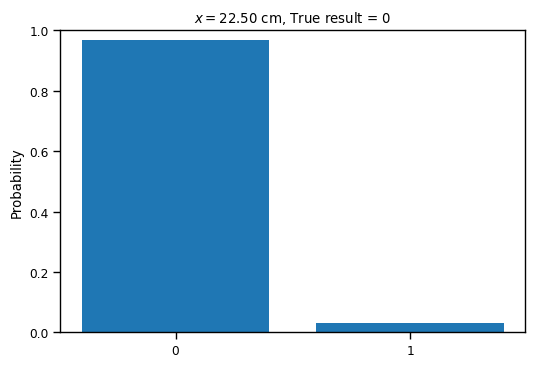

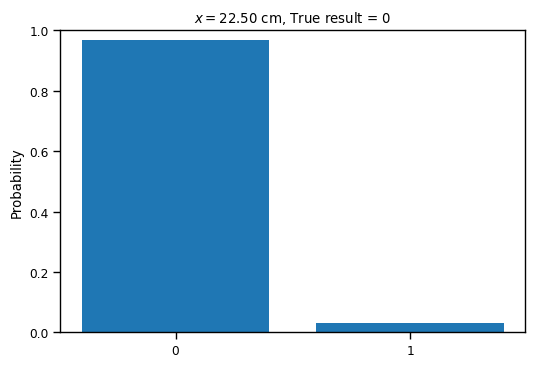

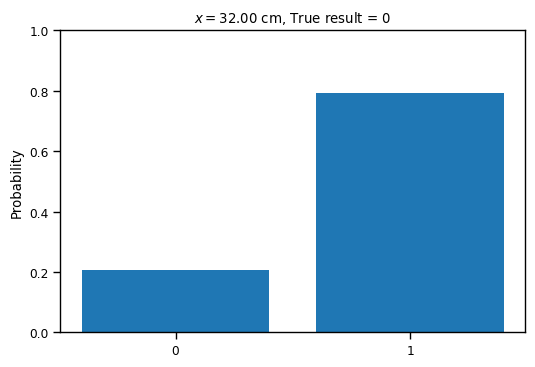

In [5]:
for i in range(x_valid.shape[0]):
    fig, ax = plt.subplots(dpi=100)
    ax.bar(np.arange(2), predictions[i])
    ax.set_title(r'$x={0:1.2f}$ cm, True result = {1:d}'.format(x_valid[i], y_valid[i]))
    ax.set_ylim([0, 1.0])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(model.classes_)
    ax.set_ylabel('Probability')

Now we are ready to pose and solve the decision-making problem.
We just need to define a cost matrix:

In [6]:
# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true
cost_matrix = np.array(
[[0.0, 1.0],
 [1.0, 0.0]]
)

Here is some code that computes the expected cost of each choice given the predicted probabilities:

In [7]:
def expected_cost(cost_matrix, prediction_prob):
    res = np.zeros((2,))
    for i in range(2):
        res[i] = cost_matrix[i, 0] * prediction_prob[0] + cost_matrix[i, 1] * prediction_prob[1]
    return res

As a demonstration, here is the expected cost of each decision for the first few validation points.
We will put a * next to the choice with minimum cost.

In [8]:
print('x\tCost of 0\tCost of 1\tTrue label\tChoice')
print('-' * 80)
for i in range(x_valid.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions[i])
    line = '{0:1.2f}\t{1:1.2f}'.format(x_valid[i], exp_c[0])
    tmp = '\t\t{0:1.2f}'.format(exp_c[1])
    correct_choice = True
    if exp_c[0] < exp_c[1]:
        line += '*'
        if y_valid[i] == 1:
            correct_choice = False
    else:
        tmp += '*'
        if y_valid[i] == 0:
            correct_choice = False
    line += tmp + '\t\t{0:d}'.format(y_valid[i])
    if correct_choice:
        line += '\t\tCORRECT'
    else:
        line += '\t\tWRONG'
    print(line)

x	Cost of 0	Cost of 1	True label	Choice
--------------------------------------------------------------------------------
40.50	1.00		0.00*		1		CORRECT
25.50	0.09*		0.91		0		CORRECT
28.50	0.30*		0.70		0		CORRECT
28.50	0.30*		0.70		1		WRONG
22.50	0.03*		0.97		0		CORRECT
36.00	0.99		0.01*		1		CORRECT
28.50	0.30*		0.70		0		CORRECT
36.00	0.99		0.01*		1		CORRECT
25.50	0.09*		0.91		0		CORRECT
25.50	0.09*		0.91		0		CORRECT
36.00	0.99		0.01*		0		WRONG
22.50	0.03*		0.97		0		CORRECT
36.00	0.99		0.01*		0		WRONG
40.50	1.00		0.00*		1		CORRECT
40.50	1.00		0.00*		1		CORRECT
22.50	0.03*		0.97		0		CORRECT
22.50	0.03*		0.97		0		CORRECT
32.00	0.79		0.21*		0		WRONG


Notice that most of the choices are correct. But there are some wrong choices.
The particularly bad wrong choices are the ones where we predict 0 (no explosion), but there is actually an explosion. Are there any such cases?

Let me now show you another very nice way to compute the expected cost for all the validation points in one line.
This is using the [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) function (Einstein summation convention).
It takes a while to understand what it does, but if you do you can shorten by a lot your linear algebra code.
The idea is that repeated indices are summed over.

In [12]:
exp_cost = np.einsum('ij,kj->ki', cost_matrix, predictions)
print(exp_cost)

[[9.99840313e-01 1.59686771e-04]
 [8.97125043e-02 9.10287496e-01]
 [3.01533272e-01 6.98466728e-01]
 [3.01533272e-01 6.98466728e-01]
 [3.14641611e-02 9.68535839e-01]
 [9.88570227e-01 1.14297726e-02]
 [3.01533272e-01 6.98466728e-01]
 [9.88570227e-01 1.14297726e-02]
 [8.97125043e-02 9.10287496e-01]
 [8.97125043e-02 9.10287496e-01]
 [9.88570227e-01 1.14297726e-02]
 [3.14641611e-02 9.68535839e-01]
 [9.88570227e-01 1.14297726e-02]
 [9.99840313e-01 1.59686771e-04]
 [9.99840313e-01 1.59686771e-04]
 [3.14641611e-02 9.68535839e-01]
 [3.14641611e-02 9.68535839e-01]
 [7.93741086e-01 2.06258914e-01]]


Here is yet another way to visualize the decisions of binary classification:

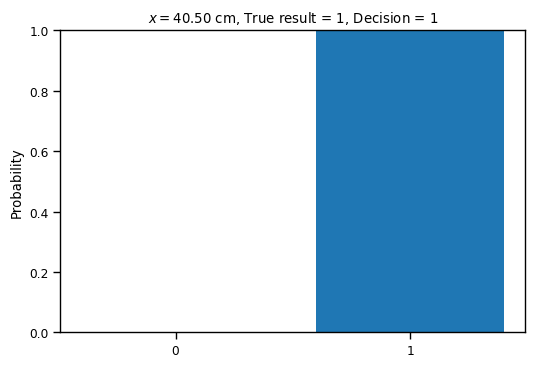

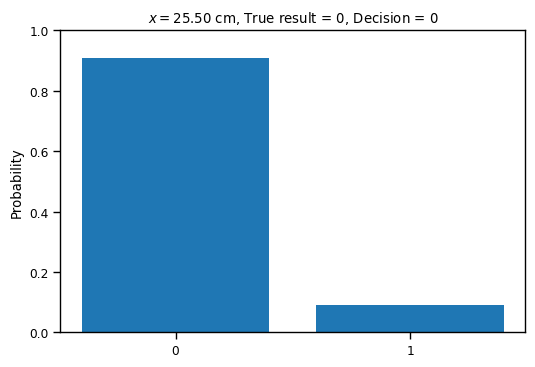

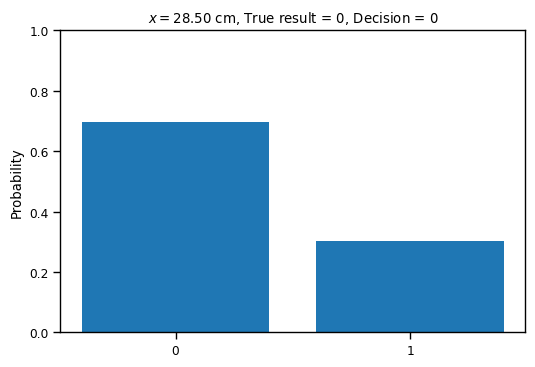

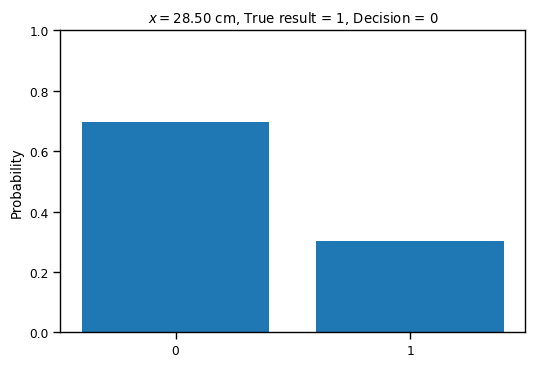

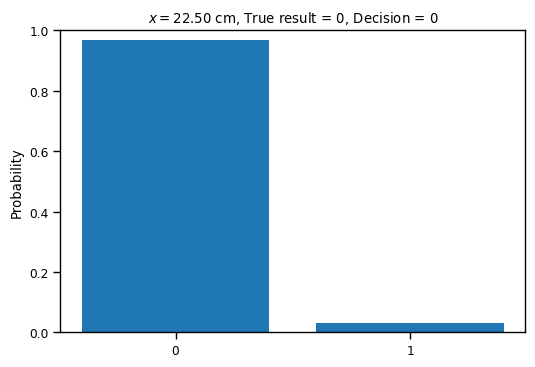

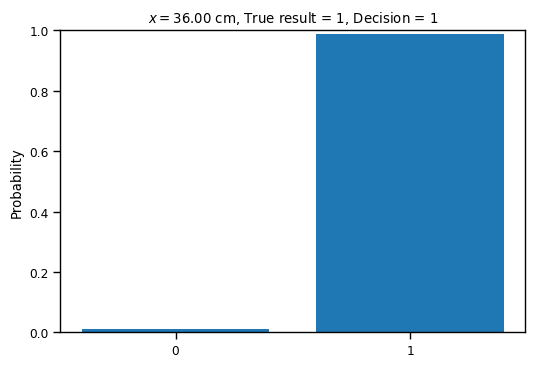

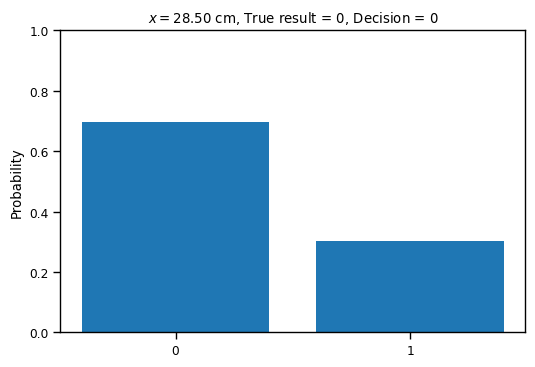

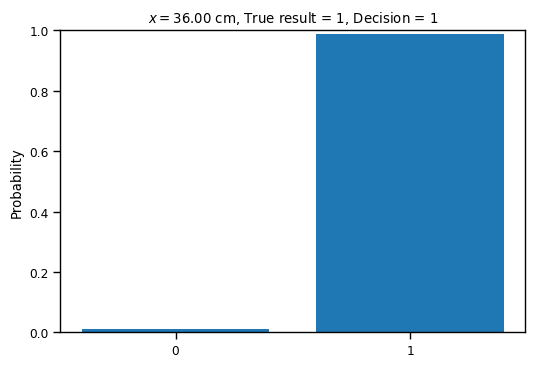

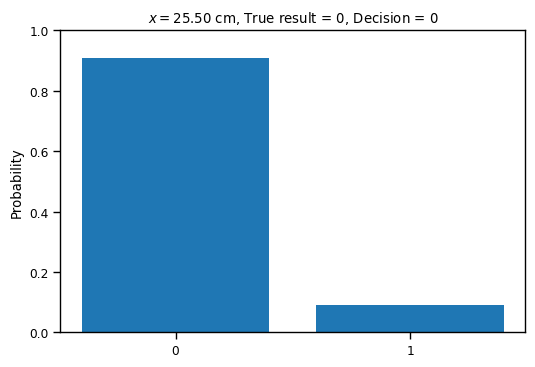

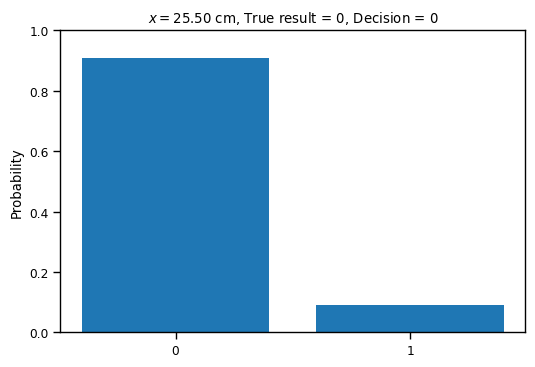

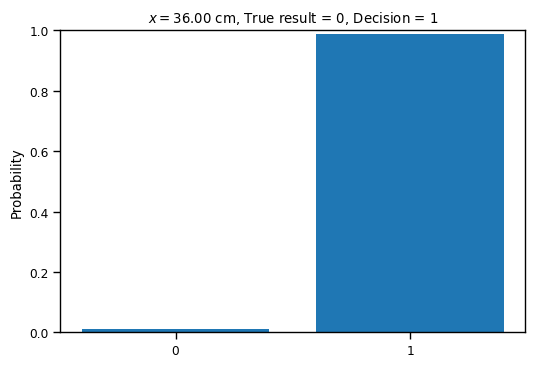

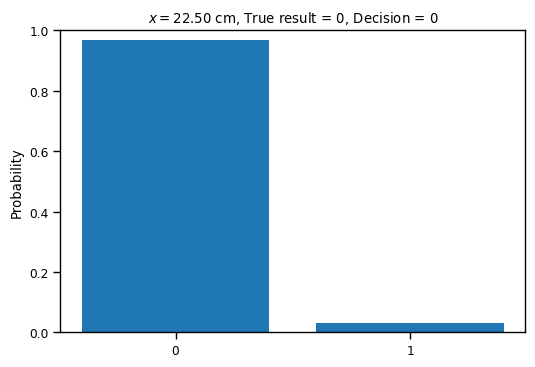

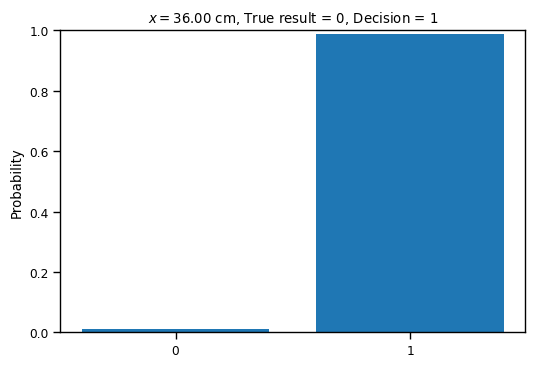

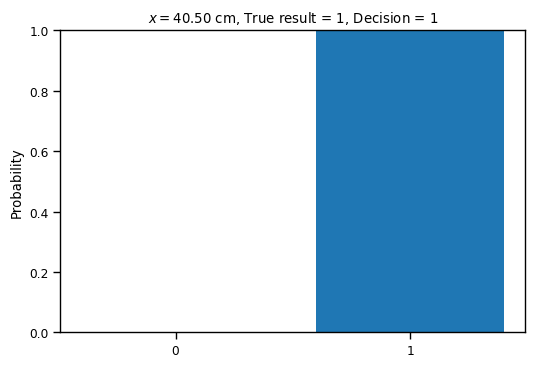

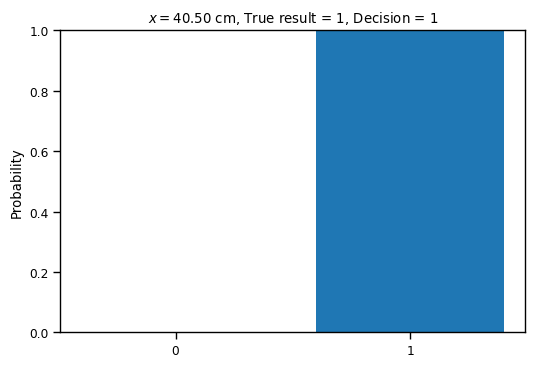

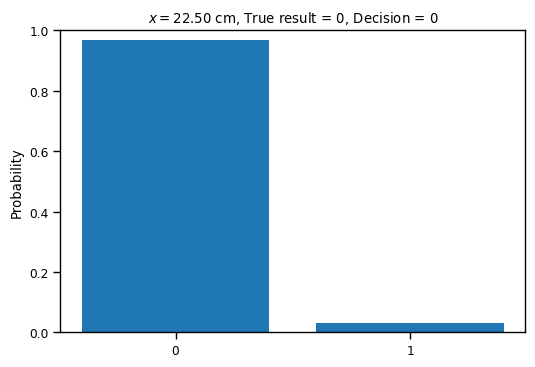

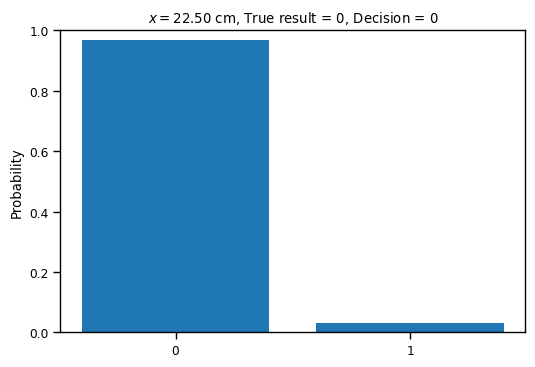

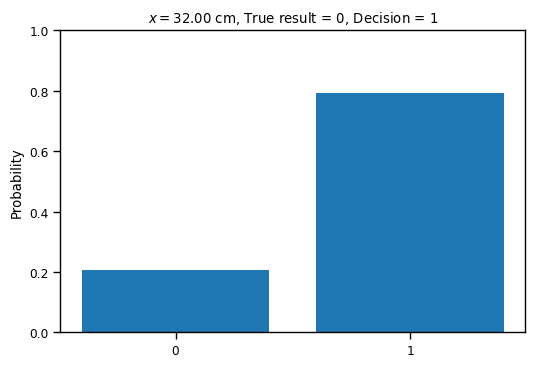

In [13]:
for i in range(x_valid.shape[0]):
    # Make decision
    decision = model.classes_[np.argmin(exp_cost[i])]
    fig, ax = plt.subplots(dpi=100)
    ax.bar(np.arange(2), predictions[i])
    ax.set_title(r'$x={0:1.2f}$ cm, True result = {1:d}, Decision = {2:d}'.format(x_valid[i], y_valid[i], decision))
    ax.set_ylim([0, 1.0])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(model.classes_)
    ax.set_ylabel('Probability')

Now let's plot the decision boundary of our model:

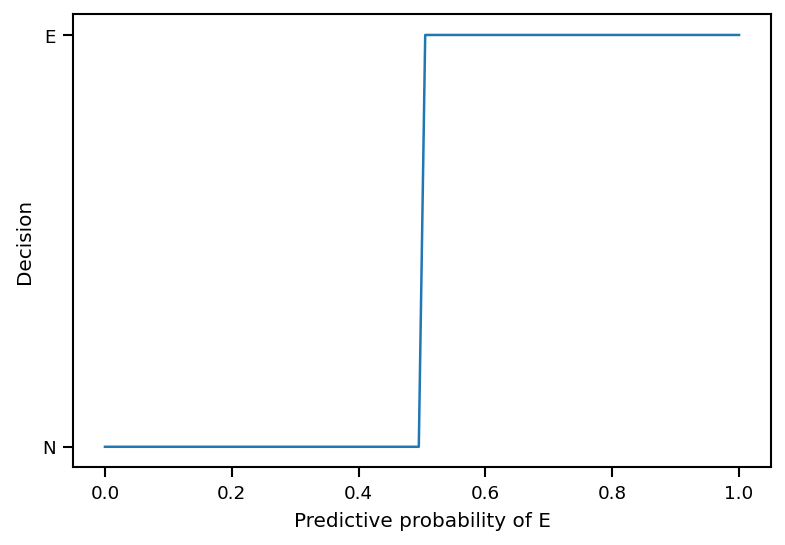

In [14]:
# Plot of decision boundary
fig, ax = plt.subplots(dpi=150)
pE = np.linspace(0, 1, 100)
pN = 1.0 - pE
probs = np.hstack([pN[:, None], pE[:, None]])
exp_cost = np.einsum('ij,kj->ki', cost_matrix, probs)
decision_idx = np.argmin(exp_cost, axis=1)
ax.plot(pE, decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['N', 'E'])
ax.set_ylabel('Decision')
ax.set_xlabel('Predictive probability of E');

### Questions

+ Repeat the analysis above with a different cost matrix that penalizes more calling a non-explosion when there is an explosion.